In [1]:
from transformers import GPT2LMHeadModel

/home/justiny/anaconda3/envs/gpt2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

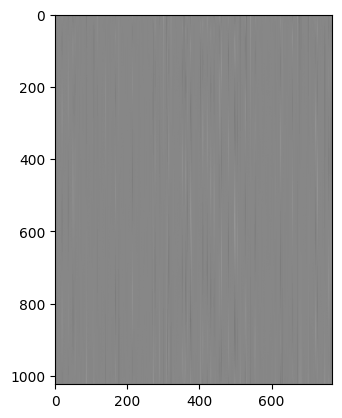

In [10]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")
plt.show()

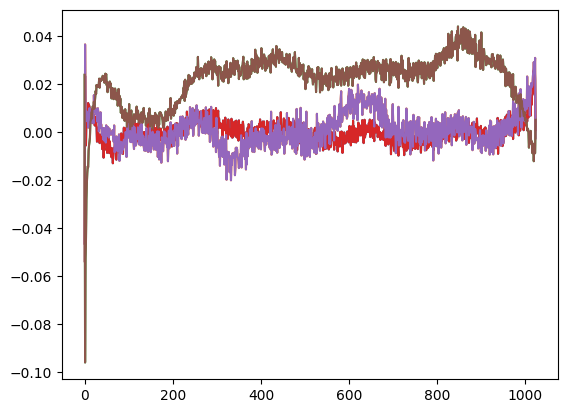

In [12]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])
plt.show()

In [13]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("hello, I'm a language model,", max_length=30, num_return_sequences=5)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[{'generated_text': "hello, I'm a language model, but what I'm really trying to do is make everything in C go as you want it, and I think"},
 {'generated_text': "hello, I'm a language model, not a syntax model. That's why I like it. I've done a lot of work on it and"},
 {'generated_text': "hello, I'm a language model, and then there's other languages.\n\nThat said, we're at a point right now that has to"},
 {'generated_text': 'hello, I\'m a language model, not a system."\n\nThat was the case, said Chris Rupal, one of the architects.'},
 {'generated_text': "hello, I'm a language model, I've been using a lot of stuff. I've been in a lot of programming languages – Java, Python"}]

In [2]:
# tiny shakespeare dataset 
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

with open('input.txt', 'r') as f:
    text = f.read()
data = text[:1000]
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [3]:
import tiktoken 
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


In [5]:
import torch 
buf = torch.tensor(tokens[:24 + 1])
x = buf[:-1].view(4, 6)
y = buf[1:].view(4, 6)
print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


test why the init of residual block parameters are scale by 1/sqrt(N) by the GPT-2 paper, where N is the number of layers; goal is to control variance

In [7]:
# standard deviation grows inside the residual stream 
x = torch.zeros(768)
n = 100 
for i in range(n):
    x += torch.randn(768)
print(x.std())

x = torch.zeros(768)
for i in range(n):
    x += n**-0.5 * torch.randn(768)
print(x.std())

tensor(10.2702)
tensor(0.9705)


In [8]:
# top-k sampling 
import torch.nn.functional as F
B, V = 5, 1000
logits = torch.rand(B, V)
probs = F.softmax(logits, dim=-1)

In [9]:
topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
ix = torch.multinomial(topk_probs, 1)
xcol = torch.gather(topk_indices, -1, ix)

In [13]:
probs

tensor([[0.0006, 0.0015, 0.0009,  ..., 0.0010, 0.0009, 0.0006],
        [0.0006, 0.0015, 0.0015,  ..., 0.0010, 0.0008, 0.0006],
        [0.0014, 0.0008, 0.0014,  ..., 0.0013, 0.0007, 0.0011],
        [0.0012, 0.0007, 0.0012,  ..., 0.0013, 0.0009, 0.0007],
        [0.0009, 0.0006, 0.0012,  ..., 0.0008, 0.0014, 0.0011]])

In [15]:
topk_probs, topk_probs.shape

(tensor([[0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
          0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
          0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015],
         [0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
          0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
          0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
          0.0016, 0.0016, 0.0016, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015],
         [0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.00

In [16]:
topk_indices, topk_indices.shape

(tensor([[252, 155,  74, 303, 692, 681, 594, 248, 301, 666, 668, 446, 509, 558,
          703, 704, 522, 516, 744, 512, 485, 667, 164, 408, 714, 809, 545, 577,
          194, 254, 942, 964, 358, 808, 739,   1, 854, 551, 777, 755, 922, 951,
          569, 202, 800, 220,  42, 975, 905, 616],
         [873, 530, 324, 789, 329, 691, 541, 632, 429, 447, 620, 522, 275, 331,
          218, 191, 919, 436, 462, 137, 934, 299, 802, 673,  59,  29,  80, 894,
          281, 496, 490, 192,  87, 718, 742, 954, 699, 672, 200, 735, 190, 410,
          400, 520, 616, 503, 992,  50, 896, 295],
         [851,  42, 958,  58, 533, 860, 623, 549, 697, 743, 456, 444, 635, 550,
          963, 967, 960, 702, 739, 136, 548, 766, 469, 645, 979, 667, 799, 326,
          385, 678, 598, 872, 395, 896, 584, 971, 637, 853, 168, 413,  34, 987,
          894, 525, 461, 640, 537, 701, 907, 764],
         [256, 515, 676, 505, 386, 209, 198, 458, 105, 802, 680, 217,  49, 892,
          508, 848, 861, 215, 989, 782, 127, 22

In [17]:
ix, ix.shape

(tensor([[22],
         [18],
         [35],
         [42],
         [18]]),
 torch.Size([5, 1]))

In [18]:
xcol, xcol.shape

(tensor([[164],
         [462],
         [971],
         [502],
         [353]]),
 torch.Size([5, 1]))

In [22]:
for i in range(ix.size()[0]):
    print(ix[i,0], topk_indices[i, ix[i,0]])

tensor(22) tensor(164)
tensor(18) tensor(462)
tensor(35) tensor(971)
tensor(42) tensor(502)
tensor(18) tensor(353)


In [ ]:
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("log124M_40B/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))